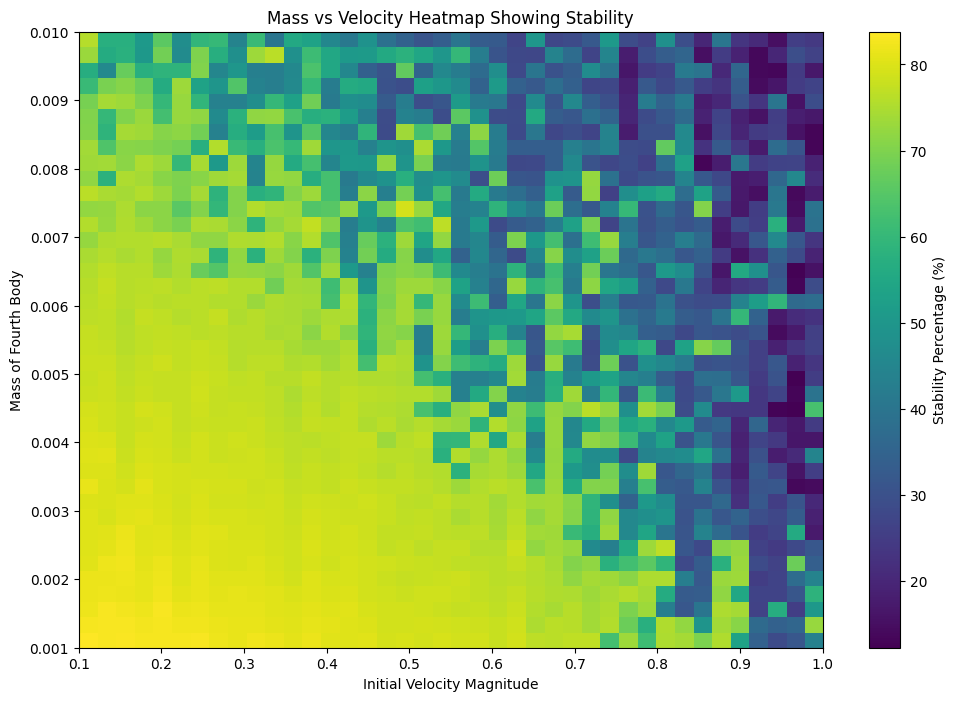

In [1]:
# Import libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Function to compute the derivatives for the 4-body problem
def four_body_derivatives(t, y, G, m1, m2, m3, m4):
    r1, r2, r3, r4 = y[:2], y[2:4], y[4:6], y[6:8]
    v1, v2, v3, v4 = y[8:10], y[10:12], y[12:14], y[14:16]

    # Distances
    r12 = np.linalg.norm(r2 - r1)
    r13 = np.linalg.norm(r3 - r1)
    r14 = np.linalg.norm(r4 - r1)
    r23 = np.linalg.norm(r3 - r2)
    r24 = np.linalg.norm(r4 - r2)
    r34 = np.linalg.norm(r4 - r3)

    # Accelerations due to gravitational forces
    a1 = G * (m2 * (r2 - r1) / r12**3 + m3 * (r3 - r1) / r13**3 + m4 * (r4 - r1) / r14**3)
    a2 = G * (m1 * (r1 - r2) / r12**3 + m3 * (r3 - r2) / r23**3 + m4 * (r4 - r2) / r24**3)
    a3 = G * (m1 * (r1 - r3) / r13**3 + m2 * (r2 - r3) / r23**3 + m4 * (r4 - r3) / r34**3)
    a4 = G * (m1 * (r1 - r4) / r14**3 + m2 * (r2 - r4) / r24**3 + m3 * (r3 - r4) / r34**3)

    return np.concatenate((v1, v2, v3, v4, a1, a2, a3, a4))

# Function to evaluate stability percentage
def evaluate_stability(x4, y4, x1, y1, x2, y2):
    r41 = np.sqrt((x4 - x1)**2 + (y4 - y1)**2)
    r42 = np.sqrt((x4 - x2)**2 + (y4 - y2)**2)

    # Check where distances fall within [0.5, 2.0]
    stable_points = ((0.5 <= r41) & (r41 <= 2.0)) & ((0.5 <= r42) & (r42 <= 2.0))
    stability_percentage = np.sum(stable_points) / len(r41) * 100
    return stability_percentage

# Constants for the three primary bodies
G = 1.0
m1, m2, m3 = 1.0, 1.0, 1.0
r1_0 = [-0.97000436, 0.24308753]
r2_0 = [0.97000436, -0.24308753]
r3_0 = [0.0, 0.0]
v1_0 = [0.466203685, 0.43236573]
v2_0 = [0.466203685, 0.43236573]
v3_0 = [-0.93240737, -0.86473146]

# Simulation parameters
T = 6.32591398  # Period of one orbit
t_span = (0, 5 * T)
t_eval = np.linspace(*t_span, 1000)

# Define mass and velocity ranges with updated intervals
masses = np.arange(0.001, 0.011, 0.00025)  # Mass range [0.001, 0.01], step 0.00025
velocities = np.arange(0.1, 1.1, 0.025)    # Velocity range [0.1, 1.0], step 0.025

# Prepare arrays to store stability results
stabilities = np.zeros((len(masses), len(velocities)))

# Run simulations for each combination of mass and velocity
for i, m4 in enumerate(masses):
    for j, v_mag in enumerate(velocities):
        v4_0 = [v_mag / np.sqrt(2), v_mag / np.sqrt(2)]  # Equal x and y velocity components
        r4_0 = [-0.08, -0.15]  # Updated initial position for the fourth body

        # Initial conditions
        y0 = np.concatenate((r1_0, r2_0, r3_0, r4_0, v1_0, v2_0, v3_0, v4_0))

        # Solve the system
        solution = solve_ivp(
            four_body_derivatives, t_span, y0, t_eval=t_eval, 
            args=(G, m1, m2, m3, m4), method='RK45', rtol=1e-8, atol=1e-10
        )

        # Extract positions
        x1, y1 = solution.y[0], solution.y[1]
        x2, y2 = solution.y[2], solution.y[3]
        x4, y4 = solution.y[6], solution.y[7]

        # Evaluate stability
        stability = evaluate_stability(x4, y4, x1, y1, x2, y2)
        stabilities[i, j] = stability

# Create a heatmap of mass vs velocity with stability
plt.figure(figsize=(12, 8))
plt.imshow(stabilities, extent=[0.1, 1.0, 0.001, 0.01], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="Stability Percentage (%)")
plt.xlabel("Initial Velocity Magnitude")
plt.ylabel("Mass of Fourth Body")
plt.title("Mass vs Velocity Heatmap Showing Stability")
plt.grid(False)
plt.show()
